# Feature Analysis: Weather Variables

## Purpose
This notebook performs comprehensive feature analysis on the **weather/environmental variables** to identify:
1. **Redundant features** - highly correlated pairs (|r| > 0.85)
2. **Multicollinearity** - VIF values indicating collinear variables
3. **Predictive relevance** - correlation with target variable (Mean Life Expectancy)
4. **Feature groupings** - hierarchical clustering patterns

## Goal
Make informed decisions about which weather features to keep/drop before modeling:
- **Drop** one variable from highly correlated pairs
- **Keep** the variable with stronger target correlation and lower VIF

## Scope
This notebook analyzes **weather variables only** (after removing irrelevant ones):
- Start with ~103 weather variables from combined dataset
- Remove demographics variables (analyzed in notebook 06)
- Remove livestock variables (8 animal types)
- Remove 67 known irrelevant weather variables
- Analyze remaining ~35-40 relevant weather variables

## Output
- Visualizations saved to: `data_cleaned/outputs_cleaned/feature_analysis/`
- Publication-ready plots (high DPI, proper sizing)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for publication quality
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Print versions for reproducibility
print("Library versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  matplotlib: {plt.matplotlib.__version__}")
print(f"  seaborn: {sns.__version__}")

Library versions:
  pandas: 2.3.3
  numpy: 1.26.4
  matplotlib: 3.10.8
  seaborn: 0.13.2


## 2. Setup Output Directory

Use the same output directory as demographics analysis.

In [2]:
# Use same output directory as notebook 06
output_dir = Path('../data_cleaned/outputs_cleaned/feature_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

print(f" Output directory: {output_dir}")
print(f"  All weather analysis plots will be saved here in high resolution (300 DPI)")

 Output directory: ../data_cleaned/outputs_cleaned/feature_analysis
  All weather analysis plots will be saved here in high resolution (300 DPI)


## 3. Load Data

Load the combined dataset from notebook 05.

In [3]:
# Load final combined dataset
df = pd.read_csv('../data_cleaned/combined_final/final_combined_all_variables.csv')

print("=" * 70)
print("DATASET LOADED")
print("=" * 70)
print(f"Shape: {df.shape}")
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")
print(f"  - Years: {sorted(df['Year'].unique())}")

DATASET LOADED
Shape: (24487, 131)
  - Rows: 24,487
  - Columns: 131
  - Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## 4. Define Variables to Exclude

### 4.1 Demographics Variables

These were analyzed in notebook 06 and should be excluded from weather analysis.

In [4]:
# Define demographics variables to exclude (same as notebook 06)
demographics_cols = [
    # Original ACS variables
    'Median Household Income',
    'Total Population',
    'Gini Index',
    'Median Age',
    'Poverty Rate',
    'Unemployment Rate',
    'Disability Rate',
    "Bachelor's Degree or Higher (%)",
    "High School Degree or Higher (%)",
    # Engineered percentage features
    'White Population (%)',
    'Hispanic Population (%)',
    'Black Population (%)',
    'Households with No Vehicle (%)',
    'Rent Burden (+50% of HI)',
    'Single Mother Families (%)'
]

# Filter to only columns that exist
demographics_cols = [col for col in demographics_cols if col in df.columns]

print(f"Demographics variables to exclude: {len(demographics_cols)}")

Demographics variables to exclude: 15


### 4.2 Livestock Variables

These will be analyzed separately if needed.

In [5]:
# Define livestock variables to exclude
livestock_cols = [
    'Buffalo', 'Cattle', 'Chicken', 'Duck', 
    'Goat', 'Horse', 'Pig', 'Sheep'
]

# Filter to only columns that exist
livestock_cols = [col for col in livestock_cols if col in df.columns]

print(f"Livestock variables to exclude: {len(livestock_cols)}")

Livestock variables to exclude: 8


### 4.3 Irrelevant Weather Variables

These 67 weather variables are known to be redundant or irrelevant and should be dropped before analysis.

In [6]:
# Define irrelevant weather variables to exclude (from user's list)
irrelevant_weather_cols = [
    'PM$_{10}$',
    'FoT PM$_{10}$ above EPA threshold', 
    'FoT PM$_{10}$ above75ᵗʰ percentile',
    'FoT PM$_{1}$ above75ᵗʰ percentile', 
    'PM$_1$', 
    'Specific humidity.1', 
    'Total column water',
    '2m dew point temperature', 
    '2m temperature',
    'PM$_{2.5}$', 
    'FoT Temperature above 90 $\\mathrm{^o F}$', 
    'FoT Temperature below 0 $\\mathrm{^o C}$',
    'FoT PM$_{2.5}$ above EPA threshold', 
    'Temperature', 
    'Surface geopotential',
    'Dust aerosol (0.03-0.55 µm) mixing ratio', 
    'Nitrogen dioxide', 
    'Peroxyacetyl nitrate', 
    'Formaldehyde',
    'Sulphur dioxide', 
    'Nitric acid', 
    'Propane',
    'Nitrogen monoxide',
    'Ozone', 
    'Hydrogen peroxide', 
    'Specific humidity',
    
    # Total AOD measurements (redundant aerosol measurements)
    'Total AOD at 469 nm', 
    'Total AOD at 550 nm', 
    'Total AOD at 670 nm', 
    'Total AOD at 865 nm',
    'Total AOD at 1240 nm',
    
    # Total column gas measurements (redundant with other air quality measures)
    'Total column carbon monoxide', 
    'Total column ethane', 
    'Total column formaldehyde',
    'Total column hydrogen peroxide', 
    'Total column hydroxyl radical', 
    'Total column isoprene', 
    'Total column methane', 
    'Total column nitric acid', 
    'Total column nitrogen dioxide', 
    'Total column ozone', 
    'Total column peroxyacetyl nitrate',
    'Total column propane', 
    'Total column sulphur dioxide', 
    'Total column water vapour',
    'Total column nitrogen monoxide',
    
    # Vertically integrated aerosol masses (redundant)
    'Vertically integrated mass of dust aerosol (0.03-0.55 µm)',
    'Vertically integrated mass of dust aerosol (0.55-9 µm)', 
    'Vertically integrated mass of dust aerosol (9-20 µm)',
    'Vertically integrated mass of hydrophilic black carbon aerosol', 
    'Vertically integrated mass of hydrophilic organic matter aerosol',
    'Vertically integrated mass of hydrophobic organic matter aerosol',
    'Vertically integrated mass of hydrophobic black carbon aerosol', 
    'Vertically integrated mass of sea salt aerosol (0.03-0.5 µm)',
    'Vertically integrated mass of sea salt aerosol (0.5-5 µm)', 
    'Vertically integrated mass of sea salt aerosol (5-20 µm)',
    'Vertically integrated mass of sulphate aerosol', 
    'Vertically integrated mass of sulphur dioxide'
]

# Filter to only columns that exist
irrelevant_weather_cols = [col for col in irrelevant_weather_cols if col in df.columns]

print(f"Irrelevant weather variables to exclude: {len(irrelevant_weather_cols)}")
print("\nCategories:")
pm_vars = [col for col in irrelevant_weather_cols if 'PM' in col]
temp_vars = [col for col in irrelevant_weather_cols if 'temperature' in col.lower() or 'Temperature' in col]
aod_vars = [col for col in irrelevant_weather_cols if 'AOD' in col]
total_column_vars = [col for col in irrelevant_weather_cols if 'Total column' in col]
vertically_vars = [col for col in irrelevant_weather_cols if 'Vertically integrated' in col]
other_vars = [col for col in irrelevant_weather_cols if col not in pm_vars + temp_vars + aod_vars + total_column_vars + vertically_vars]

print(f"  - PM variables: {len(pm_vars)}")
print(f"  - Temperature variables: {len(temp_vars)}")
print(f"  - AOD measurements: {len(aod_vars)}")
print(f"  - Total column gases: {len(total_column_vars)}")
print(f"  - Vertically integrated masses: {len(vertically_vars)}")
print(f"  - Other: {len(other_vars)}")

Irrelevant weather variables to exclude: 58

Categories:
  - PM variables: 7
  - Temperature variables: 5
  - AOD measurements: 5
  - Total column gases: 16
  - Vertically integrated masses: 12
  - Other: 13


### 4.4 Identifiers and Target Variable

In [7]:
# Define identifiers and target to exclude
identifiers = ['County', 'State', 'Year', 'fips']
target = ['Mean Life Expectancy']

# Filter to only columns that exist
identifiers = [col for col in identifiers if col in df.columns]
target = [col for col in target if col in df.columns]

print(f"Identifiers to exclude: {len(identifiers)}")
print(f"Target variable: {target}")

Identifiers to exclude: 4
Target variable: ['Mean Life Expectancy']


## 5. Extract Weather Variables

Identify weather variables by excluding all non-weather columns.

In [8]:
print("=" * 70)
print("EXTRACTING WEATHER VARIABLES")
print("=" * 70)

# Combine all columns to exclude
exclude_cols = identifiers + target + demographics_cols + livestock_cols + irrelevant_weather_cols

print(f"\nTotal columns to exclude: {len(exclude_cols)}")
print(f"  - Identifiers: {len(identifiers)}")
print(f"  - Target: {len(target)}")
print(f"  - Demographics: {len(demographics_cols)}")
print(f"  - Livestock: {len(livestock_cols)}")
print(f"  - Irrelevant weather: {len(irrelevant_weather_cols)}")

# Extract weather variables (all columns except those to exclude)
weather_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Relevant weather variables identified: {len(weather_cols)}")

# Create weather subset
weather_df = df[weather_cols + ['Mean Life Expectancy']].copy()

print(f"\nWeather subset shape: {weather_df.shape}")
print(f"  - Rows: {weather_df.shape[0]:,}")
print(f"  - Weather features: {len(weather_cols)}")
print(f"  - Target variable: 1 (Mean Life Expectancy)")

EXTRACTING WEATHER VARIABLES

Total columns to exclude: 86
  - Identifiers: 4
  - Target: 1
  - Demographics: 15
  - Livestock: 8
  - Irrelevant weather: 58

 Relevant weather variables identified: 45

Weather subset shape: (24487, 46)
  - Rows: 24,487
  - Weather features: 45
  - Target variable: 1 (Mean Life Expectancy)


## 6. List Weather Variables

Display all weather variables that will be analyzed.

In [9]:
print("=" * 70)
print(f"WEATHER VARIABLES TO ANALYZE ({len(weather_cols)})")
print("=" * 70)
print("\nVariables:")
for i, col in enumerate(sorted(weather_cols), 1):
    print(f"  {i:2}. {col}")

WEATHER VARIABLES TO ANALYZE (45)

Variables:
   1. 10m wind speed
   2. Black carbon AOD at 550 nm
   3. Carbon monoxide
   4. Dust AOD at 550 nm
   5. Dust aerosol (0.55-0.9 µm) mixing ratio
   6. Dust aerosol (0.9-20 µm) mixing ratio
   7. Ethane
   8. FoT Carbonmonoxide above75ᵗʰ percentile
   9. FoT Ethane above75ᵗʰ percentile
  10. FoT Formaldehyde above75ᵗʰ percentile
  11. FoT Hydrogen peroxide above75ᵗʰ percentile
  12. FoT Hydroxyl radical above75ᵗʰ percentile
  13. FoT Isoprene above75ᵗʰ percentile
  14. FoT Nitric acid above75ᵗʰ percentile
  15. FoT Nitrogen dioxide above75ᵗʰ percentile
  16. FoT Nitrogen monoxide above75ᵗʰ percentile
  17. FoT Ozone above75ᵗʰ percentile
  18. FoT PM$_{2.5}$ above75ᵗʰ percentile
  19. FoT Peroxyacetyl Nitrate above75ᵗʰ percentile
  20. FoT Propane above75ᵗʰ percentile
  21. FoT Sulphur dioxide above75ᵗʰ percentile
  22. FoT Temperature above75ᵗʰ percentile
  23. FoT Temperature below25ᵗʰ percentile
  24. Hydrophilic black carbon aerosol mix

## 7. Descriptive Statistics

Overview of weather variables: distributions, ranges, missing values.

In [10]:
print("=" * 70)
print("DESCRIPTIVE STATISTICS")
print("=" * 70)

# Check for missing values
missing = weather_df.isnull().sum()
if missing.sum() > 0:
    print("\n Missing values detected:")
    for col in missing[missing > 0].index:
        print(f"  {col}: {missing[col]:,} ({missing[col]/len(weather_df)*100:.2f}%)")
else:
    print("\n No missing values")

# Summary statistics
print("\nSummary statistics:")
weather_df.describe()

DESCRIPTIVE STATISTICS

 No missing values

Summary statistics:


,Black carbon AOD at 550 nm,Dust AOD at 550 nm,Land-sea mask,Mean sea level pressure,Organic matter AOD at 550 nm,Sea salt AOD at 550 nm,Sulphate AOD at 550 nm,Surface pressure,Carbon monoxide,Dust aerosol (0.55-0.9 µm) mixing ratio,...,FoT Nitrogen dioxide above75ᵗʰ percentile,FoT Nitrogen monoxide above75ᵗʰ percentile,FoT Ozone above75ᵗʰ percentile,FoT Hydrogen peroxide above75ᵗʰ percentile,FoT PM$_{2.5}$ above75ᵗʰ percentile,FoT Propane above75ᵗʰ percentile,FoT Sulphur dioxide above75ᵗʰ percentile,FoT Temperature above75ᵗʰ percentile,FoT Temperature below25ᵗʰ percentile,Mean Life Expectancy
count,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,2.448700e+04,2.448700e+04,...,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000,24487.000000
mean,0.006957,0.006823,0.940175,101717.215378,0.074638,0.007459,0.050543,96732.896935,1.630836e-07,7.073325e-10,...,27.023090,15.376378,43.344840,25.527466,34.349782,26.494420,23.346542,43.663401,36.309714,77.352793
std,0.001643,0.004220,0.117245,112.263376,0.013602,0.004336,0.015252,5275.659436,2.044880e-08,5.765845e-10,...,14.714983,9.153050,6.302588,9.318040,10.506852,19.200888,23.766495,15.496757,15.786625,2.537593
min,0.002853,0.000965,0.134455,101190.734156,0.025448,0.002506,0.016799,71376.504085,9.749192e-08,3.756149e-11,...,0.223881,0.717213,19.774590,0.239071,3.219178,0.000000,0.000000,1.980874,0.000000,67.088033
25%,0.005912,0.003684,0.962231,101640.656337,0.067629,0.004796,0.037099,96184.613921,1.517833e-07,2.999832e-10,...,15.479452,8.915922,39.452055,18.458904,27.306548,11.815068,0.922131,32.864163,24.212329,75.614153
50%,0.006670,0.005818,0.984592,101728.993033,0.075164,0.005836,0.053757,98358.289992,1.636864e-07,5.409942e-10,...,25.785519,13.732877,43.731343,24.417808,36.369863,22.438525,15.932836,42.739726,37.739726,77.471893
75%,0.007674,0.008871,0.993097,101800.802399,0.083752,0.008669,0.062913,99859.437344,1.730789e-07,9.519616e-10,...,37.910448,19.535519,47.157534,31.830601,42.020548,40.684932,40.582192,53.512611,48.664384,79.047978
max,0.020297,0.030306,0.999933,102016.076978,0.119383,0.046040,0.107583,101854.756871,6.502018e-07,8.035914e-09,...,86.407104,76.061644,88.424658,79.212329,76.161202,98.664384,96.815068,99.280822,79.781421,92.253858


## 8. Inter-Feature Correlation Analysis

### 8.1 Correlation Matrix Heatmap (Without Annotations)

With 35-40 variables, annotations would be too cluttered. Show color patterns only.

 Saved: weather_correlation_matrix.png


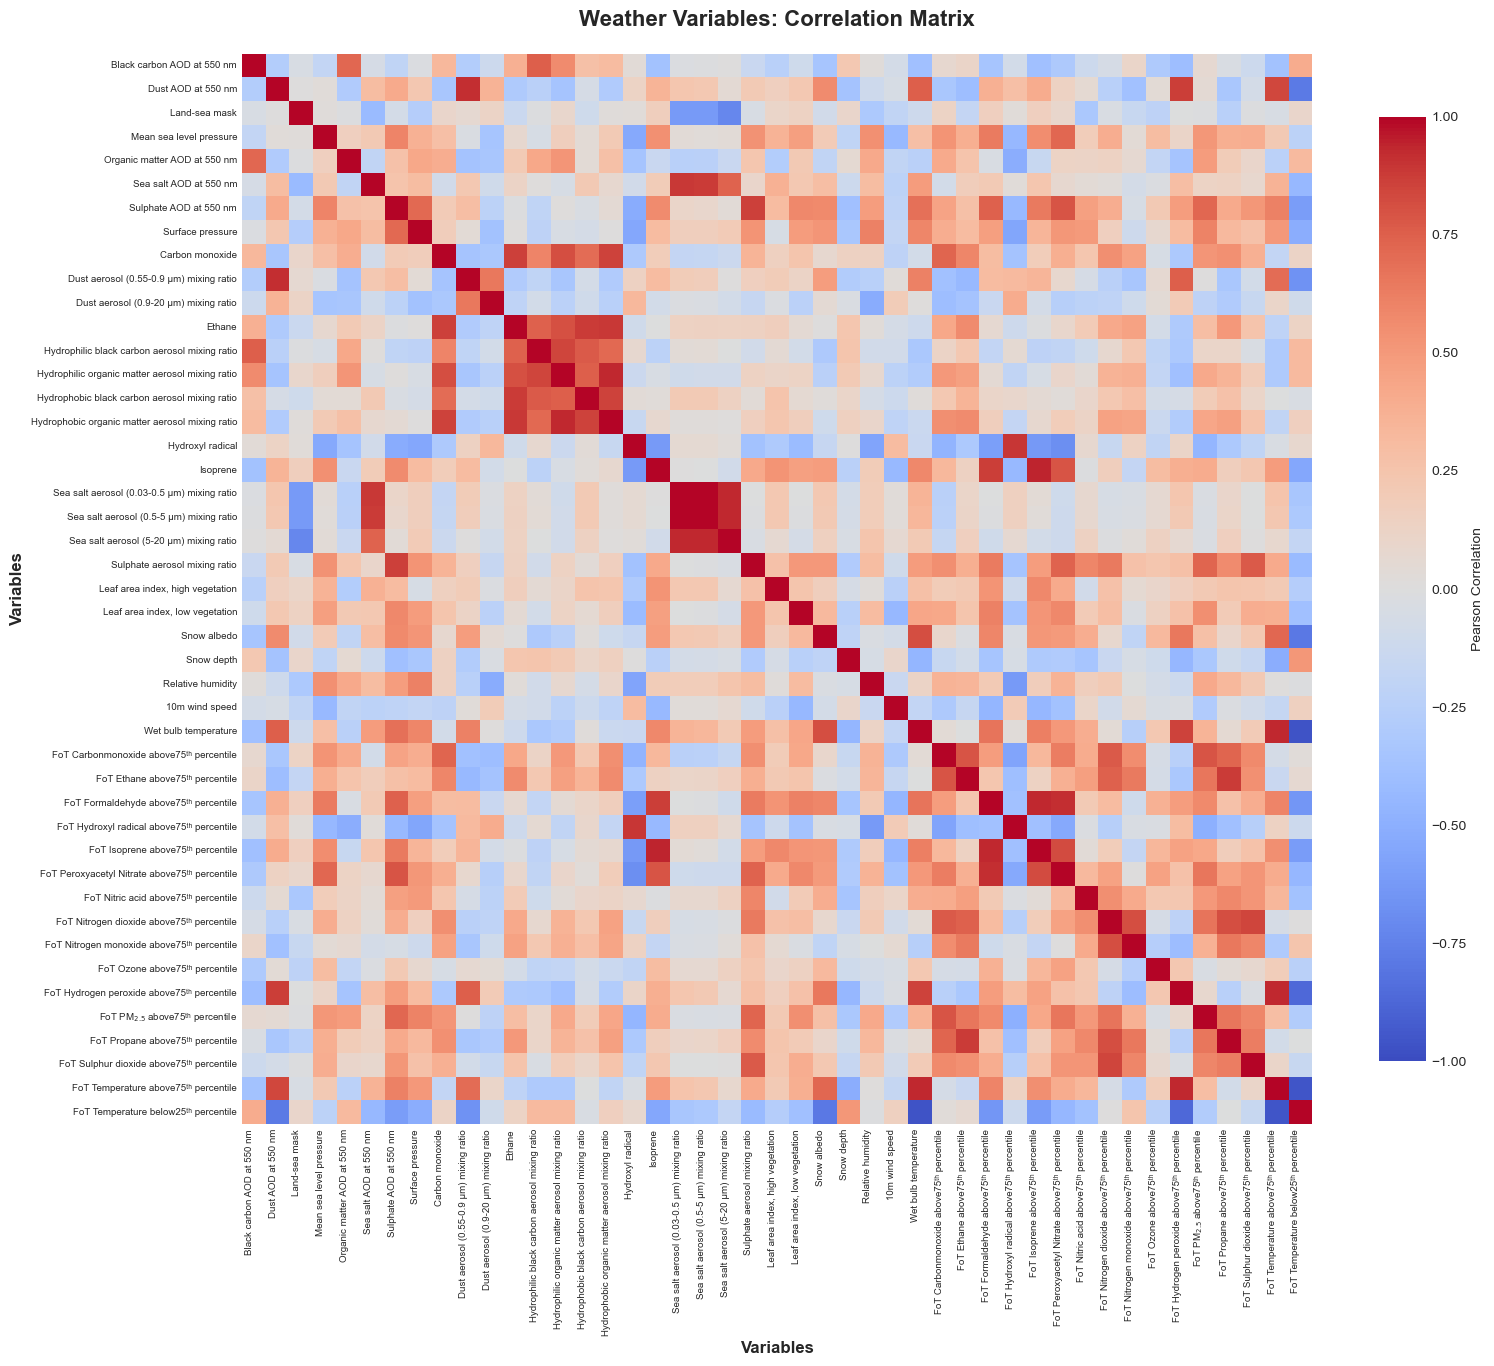


Note: Due to the large number of variables, the heatmap shows color patterns only.
      See the high correlation pairs table below for specific values.


In [11]:
# Calculate correlation matrix (exclude target variable for now)
corr_matrix = weather_df[weather_cols].corr()

# Create publication-quality heatmap WITHOUT annotations
fig, ax = plt.subplots(figsize=(16, 14))

# Create heatmap WITHOUT annotations (too many variables)
sns.heatmap(corr_matrix, 
            annot=False,  # No annotations - would be too cluttered
            cmap='coolwarm',  # Diverging colormap
            center=0,    # Center colormap at 0
            vmin=-1, vmax=1,  # Fix scale
            square=True,  # Square cells
            linewidths=0,  # No grid lines (too cluttered)
            cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8},
            ax=ax)

plt.title('Weather Variables: Correlation Matrix', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12, fontweight='bold')
plt.ylabel('Variables', fontsize=12, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'weather_correlation_matrix.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: weather_correlation_matrix.png")
plt.show()

print("\nNote: Due to the large number of variables, the heatmap shows color patterns only.")
print("      See the high correlation pairs table below for specific values.")

### 8.2 High Correlation Pairs

Identify variable pairs with |correlation| > 0.85 (indicating potential redundancy).

In [12]:
print("=" * 70)
print("HIGH CORRELATION PAIRS (|r| > 0.85)")
print("=" * 70)

# Find high correlation pairs
threshold = 0.85
high_corr_pairs = []

# Iterate through correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nFound {len(high_corr_df)} pairs with |correlation| > {threshold}:")
    print("\n" + high_corr_df.to_string(index=False))
    
    # Save to CSV
    high_corr_df.to_csv(output_dir / 'weather_high_correlation_pairs.csv', index=False)
    print(f"\n Saved: weather_high_correlation_pairs.csv")
else:
    print(f"\n No variable pairs with |correlation| > {threshold}")

HIGH CORRELATION PAIRS (|r| > 0.85)

Found 26 pairs with |correlation| > 0.85:

                                     Variable 1                                      Variable 2  Correlation
    Sea salt aerosol (0.03-0.5 µm) mixing ratio        Sea salt aerosol (0.5-5 µm) mixing ratio     0.999637
                           Wet bulb temperature            FoT Temperature below25ᵗʰ percentile    -0.967276
           FoT Temperature above75ᵗʰ percentile            FoT Temperature below25ᵗʰ percentile    -0.954340
                                       Isoprene               FoT Isoprene above75ᵗʰ percentile     0.943242
       Sea salt aerosol (0.5-5 µm) mixing ratio         Sea salt aerosol (5-20 µm) mixing ratio     0.937121
          FoT Formaldehyde above75ᵗʰ percentile               FoT Isoprene above75ᵗʰ percentile     0.934695
                           Wet bulb temperature            FoT Temperature above75ᵗʰ percentile     0.933475
    Sea salt aerosol (0.03-0.5 µm) mixing ratio 

### 8.3 Hierarchical Clustering Dendrogram

Visualize natural groupings of correlated weather variables using hierarchical clustering.

 Saved: weather_dendrogram.png


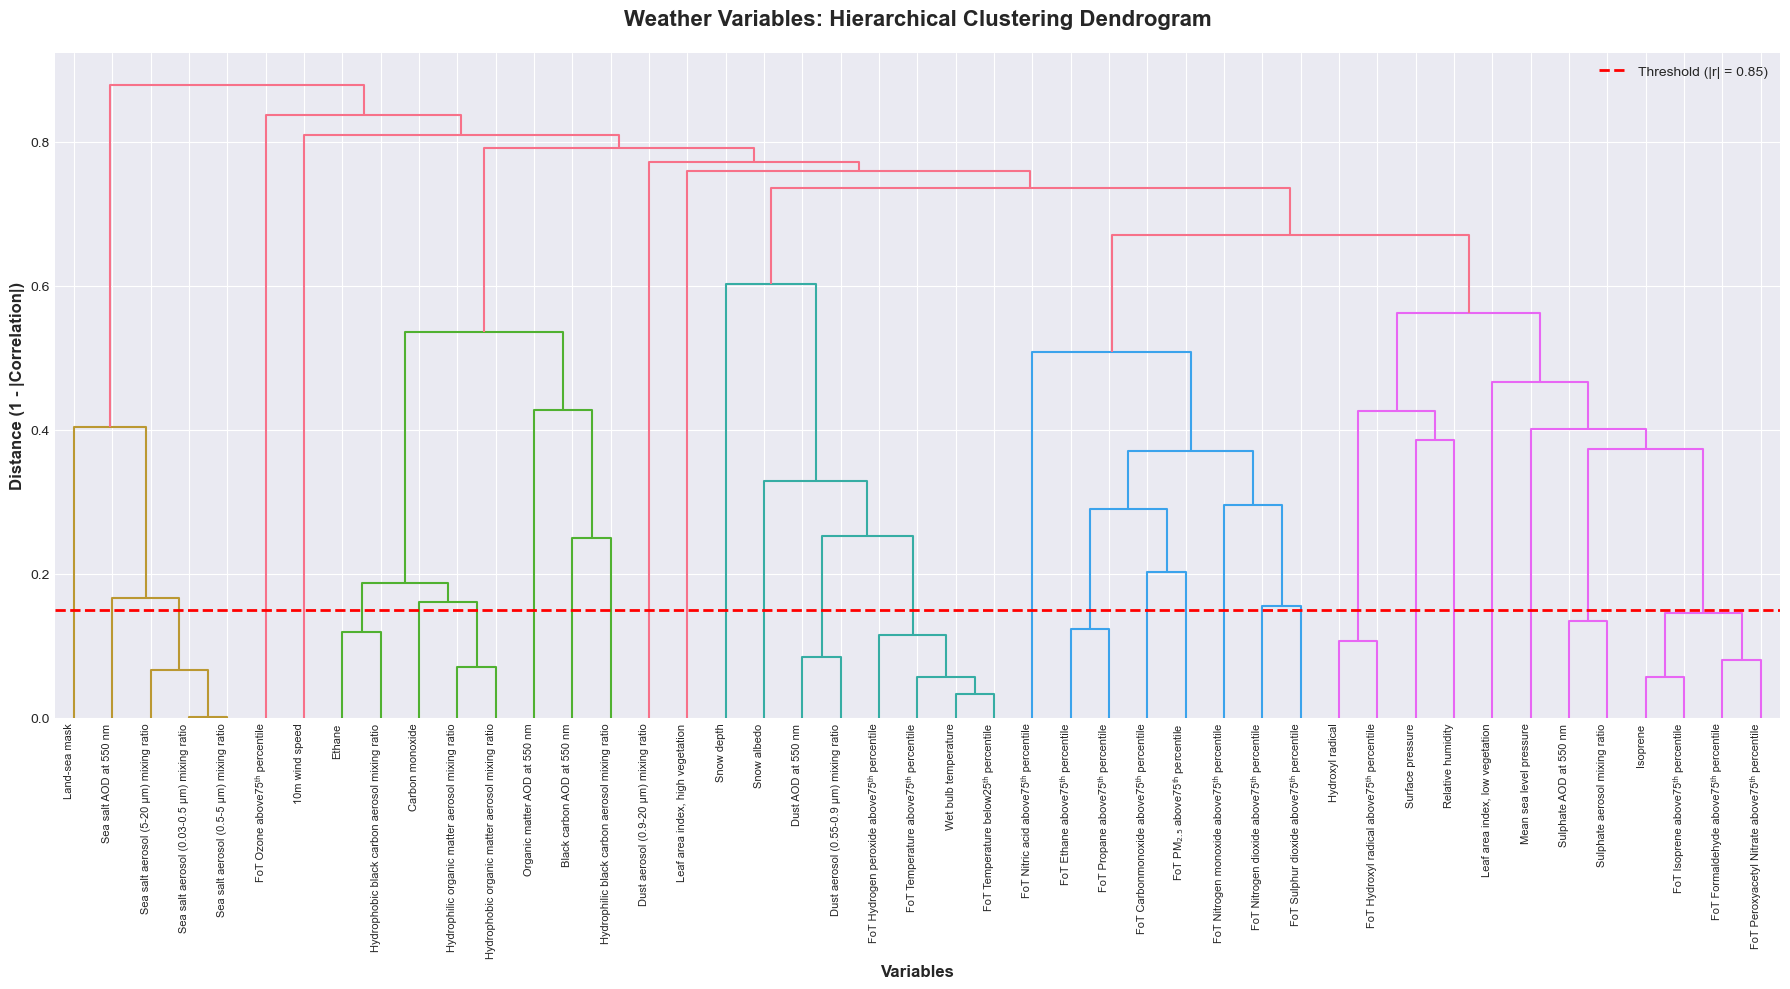


Interpretation:
  - Variables connected below the red line (threshold) are highly correlated
  - Consider keeping only one representative from each tight cluster


In [13]:
# Calculate distance matrix from correlations
# Distance = 1 - |correlation|
distance_matrix = 1 - np.abs(corr_matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Create publication-quality dendrogram
fig, ax = plt.subplots(figsize=(18, 10))

dendrogram(linkage_matrix, 
           labels=corr_matrix.columns,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False,
           leaf_font_size=8,
           ax=ax)

plt.title('Weather Variables: Hierarchical Clustering Dendrogram', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12, fontweight='bold')
plt.ylabel('Distance (1 - |Correlation|)', fontsize=12, fontweight='bold')
plt.xticks(rotation=90, ha='right')

# Add horizontal line at threshold
threshold_distance = 1 - threshold
plt.axhline(y=threshold_distance, color='r', linestyle='--', 
            linewidth=2, label=f'Threshold (|r| = {threshold})')
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'weather_dendrogram.png', 
            dpi=300, bbox_inches='tight')
print(" Saved: weather_dendrogram.png")
plt.show()

print("\nInterpretation:")
print("  - Variables connected below the red line (threshold) are highly correlated")
print("  - Consider keeping only one representative from each tight cluster")

## 9. Relationship with Target Variable

### 9.1 Feature-Target Correlation

Calculate correlation of each weather feature with Mean Life Expectancy.

In [ ]:
# Calculate correlation with target variable
target_corr = weather_df[weather_cols].corrwith(weather_df['Mean Life Expectancy'])
target_corr = target_corr.sort_values(key=abs, ascending=False)

print("=" * 70)
print("FEATURE CORRELATION WITH TARGET (Mean Life Expectancy)")
print("=" * 70)
print("\nRanked by absolute correlation:")
print("\n" + target_corr.to_string())

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 12))

colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, ax=ax)

plt.title('Weather Variables: Correlation with Mean Life Expectancy', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Pearson Correlation', fontsize=12, fontweight='bold')
plt.ylabel('Weather Variables', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'weather_target_correlation_barplot.png', 
            dpi=300, bbox_inches='tight')
print("\n Saved: weather_target_correlation_barplot.png")
plt.show()

# Save to CSV
target_corr_df = pd.DataFrame({
    'Variable': target_corr.index,
    'Correlation with Target': target_corr.values
})
target_corr_df.to_csv(output_dir / 'weather_target_correlations.csv', index=False)
print(" Saved: weather_target_correlations.csv")

### 9.2 Bivariate Scatter Plots

Visualize relationships between top correlated weather features and target variable.

In [ ]:
# Select top 9 features by absolute correlation
top_features = target_corr.abs().nlargest(9).index.tolist()

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Scatter plot with regression line
    ax.scatter(weather_df[feature], 
               weather_df['Mean Life Expectancy'],
               alpha=0.3, s=10, color='steelblue')
    
    # Add regression line
    z = np.polyfit(weather_df[feature].dropna(), 
                   weather_df.loc[weather_df[feature].notna(), 'Mean Life Expectancy'],
                   1)
    p = np.poly1d(z)
    ax.plot(weather_df[feature].sort_values(), 
            p(weather_df[feature].sort_values()),
            "r--", linewidth=2, alpha=0.8)
    
    # Labels and correlation
    corr_val = target_corr[feature]
    ax.set_xlabel(feature, fontsize=9, fontweight='bold')
    ax.set_ylabel('Mean Life Expectancy', fontsize=9, fontweight='bold')
    ax.set_title(f'r = {corr_val:.3f}', fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Top 9 Weather Features vs. Mean Life Expectancy', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'weather_top_features_scatter_plots.png', 
            dpi=300, bbox_inches='tight')
print("✓ Saved: weather_top_features_scatter_plots.png")
plt.show()

## 10. Multicollinearity Detection (VIF)

Calculate Variance Inflation Factor (VIF) for each weather variable.
- **VIF < 5**: Low multicollinearity
- **VIF 5-10**: Moderate multicollinearity
- **VIF > 10**: High multicollinearity (problematic)

In [ ]:
# Prepare data for VIF calculation (remove any NaN values)
vif_data = weather_df[weather_cols].dropna()

print("=" * 70)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 70)
print("\nCalculating VIF for each variable...")
print("(This may take several minutes for 35+ variables)\n")

# Calculate VIF for each feature
vif_results = []
for i, col in enumerate(weather_cols):
    try:
        vif_value = variance_inflation_factor(vif_data.values, i)
        vif_results.append({
            'Variable': col,
            'VIF': vif_value
        })
        print(f"  ✓ [{i+1}/{len(weather_cols)}] {col}: VIF = {vif_value:.2f}")
    except Exception as e:
        print(f"  ✗ [{i+1}/{len(weather_cols)}] {col}: Error calculating VIF ({str(e)})")
        vif_results.append({
            'Variable': col,
            'VIF': np.nan
        })

# Create VIF dataframe
vif_df = pd.DataFrame(vif_results)
vif_df = vif_df.sort_values('VIF', ascending=False)

print("\n" + "=" * 70)
print("VIF RESULTS (sorted by VIF value):")
print("=" * 70)
print("\n" + vif_df.to_string(index=False))

# Interpretation
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠ {len(high_vif)} variables with VIF > 10 (high multicollinearity):")
    for _, row in high_vif.iterrows():
        print(f"  - {row['Variable']}: VIF = {row['VIF']:.2f}")
else:
    print("\n✓ No variables with VIF > 10")

# Save to CSV
vif_df.to_csv(output_dir / 'weather_vif_analysis.csv', index=False)
print("\n✓ Saved: weather_vif_analysis.csv")

In [ ]:
# Visualize VIF values
fig, ax = plt.subplots(figsize=(10, 12))

# Color code by severity
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' 
          for x in vif_df['VIF'].values]

vif_df.set_index('Variable')['VIF'].plot(kind='barh', color=colors, ax=ax)

plt.title('Weather Variables: Variance Inflation Factor (VIF)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('VIF Value', fontsize=12, fontweight='bold')
plt.ylabel('Weather Variables', fontsize=12, fontweight='bold')

# Add reference lines
plt.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='VIF = 5 (Moderate threshold)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='VIF = 10 (High threshold)')

plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(output_dir / 'weather_vif_barplot.png', 
            dpi=300, bbox_inches='tight')
print("✓ Saved: weather_vif_barplot.png")
plt.show()

## 11. Decision Framework

### 11.1 Combine All Metrics

Create comprehensive table with all relevant metrics for decision-making.

In [ ]:
# Combine all metrics into one dataframe
decision_df = pd.DataFrame({
    'Variable': weather_cols,
    'Target_Correlation': [target_corr[col] for col in weather_cols],
    'Abs_Target_Correlation': [abs(target_corr[col]) for col in weather_cols],
    'VIF': [vif_df[vif_df['Variable'] == col]['VIF'].values[0] if col in vif_df['Variable'].values else np.nan 
            for col in weather_cols]
})

# Sort by absolute target correlation (descending)
decision_df = decision_df.sort_values('Abs_Target_Correlation', ascending=False)

print("=" * 70)
print("COMPREHENSIVE DECISION METRICS")
print("=" * 70)
print("\n" + decision_df.to_string(index=False))

# Save to CSV
decision_df.to_csv(output_dir / 'weather_feature_decision_metrics.csv', index=False)
print("\n✓ Saved: weather_feature_decision_metrics.csv")

### 11.2 Decision Guidelines

For each highly correlated pair (|r| > 0.85), apply the following decision rules:

**Decision Criteria:**
1. **Target Correlation**: Keep variable with higher |correlation| with Mean Life Expectancy
2. **VIF**: Prefer variable with lower VIF (less multicollinearity)
3. **Interpretability**: If metrics are similar, keep more interpretable variable

**Actions:**
- Document which variable to **KEEP** and which to **DROP**
- Provide clear reasoning for each decision

In [ ]:
print("=" * 70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 70)

if 'high_corr_df' in locals() and len(high_corr_df) > 0:
    print(f"\nAnalyzing {len(high_corr_df)} highly correlated pairs...\n")
    
    recommendations = []
    
    for idx, row in high_corr_df.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        corr = row['Correlation']
        
        # Get metrics for both variables
        var1_metrics = decision_df[decision_df['Variable'] == var1].iloc[0]
        var2_metrics = decision_df[decision_df['Variable'] == var2].iloc[0]
        
        print(f"Pair {idx+1}: {var1} vs {var2}")
        print(f"  Inter-correlation: {corr:.3f}")
        print(f"\n  {var1}:")
        print(f"    - Target correlation: {var1_metrics['Target_Correlation']:.3f}")
        print(f"    - VIF: {var1_metrics['VIF']:.2f}")
        print(f"\n  {var2}:")
        print(f"    - Target correlation: {var2_metrics['Target_Correlation']:.3f}")
        print(f"    - VIF: {var2_metrics['VIF']:.2f}")
        
        # Decision logic
        var1_score = var1_metrics['Abs_Target_Correlation'] - (var1_metrics['VIF'] / 100)
        var2_score = var2_metrics['Abs_Target_Correlation'] - (var2_metrics['VIF'] / 100)
        
        if var1_score > var2_score:
            keep, drop = var1, var2
            reason = f"Higher target correlation ({var1_metrics['Abs_Target_Correlation']:.3f} vs {var2_metrics['Abs_Target_Correlation']:.3f})"
        else:
            keep, drop = var2, var1
            reason = f"Higher target correlation ({var2_metrics['Abs_Target_Correlation']:.3f} vs {var1_metrics['Abs_Target_Correlation']:.3f})"
        
        print(f"\n  → RECOMMENDATION: KEEP '{keep}', DROP '{drop}'")
        print(f"    Reason: {reason}")
        print("\n" + "-" * 70 + "\n")
        
        recommendations.append({
            'Correlated Pair': f"{var1} <-> {var2}",
            'Correlation': corr,
            'Keep': keep,
            'Drop': drop,
            'Reason': reason
        })
    
    # Save recommendations
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df.to_csv(output_dir / 'weather_feature_selection_recommendations.csv', index=False)
    print("✓ Saved: weather_feature_selection_recommendations.csv")
    
else:
    print("\n✓ No highly correlated pairs detected.")
    print("  All weather features can be retained.")

## 12. Summary

**Analysis Completed:**
- ✓ Identified weather variables (excluded demographics, livestock, irrelevant weather)
- ✓ Descriptive statistics
- ✓ Inter-feature correlation matrix (heatmap without annotations)
- ✓ High correlation pairs identification (|r| > 0.85)
- ✓ Hierarchical clustering (dendrogram)
- ✓ Feature-target correlations
- ✓ Bivariate scatter plots (top 9 features)
- ✓ Multicollinearity detection (VIF)
- ✓ Decision recommendations

**Output Files:**
All visualizations and tables saved to: `data_cleaned/outputs_cleaned/feature_analysis/`

**Next Steps:**
1. Review recommendations and make final decisions
2. Combine decisions from both notebooks (demographics + weather)
3. Create final reduced dataset with selected features only
4. Begin machine learning modeling

In [ ]:
# List all generated files for weather analysis
print("=" * 70)
print("OUTPUT FILES GENERATED (WEATHER ANALYSIS)")
print("=" * 70)
print(f"\nDirectory: {output_dir}\n")

weather_files = sorted([f for f in output_dir.glob('weather_*')])
for file in weather_files:
    size_kb = file.stat().st_size / 1024
    print(f"  ✓ {file.name} ({size_kb:.1f} KB)")

print(f"\nTotal weather analysis files: {len(weather_files)}")

# Show all files in directory
all_files = sorted(output_dir.glob('*'))
print(f"\nTotal files in directory (demographics + weather): {len(all_files)}")